<a id='top'></a>
# Using projects with archives/git

MLRun projects can be stored and versioned in an archive, and they can be loaded and executed in different client or CI/CD environments.
Project functions can access code in the repository and use relative paths.

In this document:
- [**Create a new project and register functions**](#create-project)
- [**Load a project from local/remote archive**](#load)
- [**Deploy and execute job functions**](#deploy-job)
- [**Deploy and execute real-time functions**](#deploy-rt)


In [1]:
import mlrun

> 2022-05-25 11:33:52,072 [warning] Failed resolving version info. Ignoring and using defaults
> 2022-05-25 11:33:54,702 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}


<a id='create-project'></a>
## Create a new project and registering functions

To define a new project from scratch, use `mlrun.new_project()`. You must specify a `name`, 
location for the `context` directory (defaults to `./`) and other optional parameters (see below).
The `context` dir holds the configuration, code, and workflow files. File paths in the project are relative to the context root. Read more about projects [in the docs site](https://docs.mlrun.org/en/latest/projects/project.html).


In [2]:
project_name = "git-proj"
project = mlrun.new_project(project_name, user_project=True, init_git=True, description="my new project")

### Register project functions

Function with basic attributes such as code, requierments, image, etc. can be registered using the `set_function()` command

Functions can be created from a single code/notebook file or have access to the entire project context directory (by adding the `with_repo=True` flag, it will guarentee the project context is cloned into the function runtime environment).

    # example: register a notebook file as a function
    project.set_function('mynb.ipynb', name='test-function', image="mlrun/mlrun", handler="run_test")

**Register simple batch/real-time functions which use libraries from the project context:**

In [3]:
# define a job (batch) function which uses code/libs from the project repo
project.set_function(
    name="myjob", handler="job_func.job_handler",
    image="mlrun/mlrun", kind="job", with_repo=True,
)

# define a nuclio (real-time) function which uses code/libs from the project repo
# in Nuclio the handler convention is module[.submodule]:function-handler
project.set_function(
    name="nuclio", handler="nuclio_func:nuclio_handler",
    image="mlrun/mlrun", kind="nuclio", with_repo=True,
)

**Register functions by reference (serving graph function example):**

if you need to specify advanced function attributes you can create a function object and pass it as the first parameter in the `set_function` call.
To keep a cleaner project it is recomended to save such functions to a `.yaml` file inside the context, and register that `.yaml` file, see the example below of a multi-step serving graph function. 


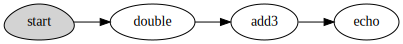

In [4]:
# define a serving graph function with 3 steps (*2, +3, echo)
serving = mlrun.new_function("serving", kind="serving", image="mlrun/mlrun")
graph = serving.set_topology("flow")
graph.to(name="double", handler="mylib.double") \
     .to(name="add3", handler="mylib.add3") \
     .to(name="echo", handler="mylib.echo").respond()

# plot the serving graph
serving.spec.graph.plot(rankdir="LR")

In [5]:
# save the function definition into a .yaml file and register it in the project
serving.export("serving.yaml")
project.set_function("serving.yaml", name="serving", with_repo=True)

> 2022-05-25 11:33:56,030 [info] function spec saved to path: serving.yaml


**Register additional project objects and metadata:**

You can define other objects (workflows, artifacts, secrets) and parameters in the project and use them in your functions, for example:

```python
    # register a simple named artifact in the project (to be used in workflows)  
    data_url = 'https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv'
    project.set_artifact('data', target_path=data_url)

    # add a multi-stage workflow (./myflow.py) to the project with the name 'main' and save the project 
    project.set_workflow('main', "./myflow.py")
    
    # read env vars from dict or file and set as project secrets
    project.set_secrets({"SECRET1": "value"})
    project.set_secrets(file_path="secrets.env")
    
    project.spec.params = {"x": 5}
```

**Save the project:**

In [6]:
# save the project in the db (and into the project.yaml file)
project.save()

see the generated project file: [**project.yaml**](project.yaml)

### Push the project code/metadata into an Archive

Use standard Git commands to push the current project tree into a git archive, make sure you `.save()` the project before pushing it

    git remote add origin <server>
    git commit -m "Commit message"
    git push origin master

Alternatively you can use MLRun SDK calls:
- `project.create_remote(git_uri, branch=branch)` - to register the remote Git path
- `project.push()` - save project state and commit/push updates to remote git repo

you can also save the project content and metadata into a local or remote `.zip` archive, examples: 

    project.export("../archive1.zip")
    project.export("s3://my-bucket/archive1.zip")
    project.export(f"v3io://projects/{project.name}/archive1.zip")
    

<a id='load'></a>
## Load a project from local/remote archive 

The project metadata and context (code and configuration) can be loaded and initialized using the {py:meth}`~mlrun.projects.load_project` method.
when `url` (of the git/zip/tar) is specified it clones a remote repo into the local `context` dir.

    # load the project and run the 'main' workflow
    project = load_project(context="./", name="myproj", url="git://github.com/mlrun/project-archive.git")
    project.run("main", arguments={'data': data_url})

Projects can also be loaded and executed using the CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-archive.git" .
    mlrun project -r main -w -a data=<data-url> .

In [7]:
# load the project in the current context dir
project = mlrun.load_project("./")

<a id='deploy-job'></a>
## Deploy and execute job functions

You can execute functions locally for test and debug, just turn on the `local=True` flag

In [8]:
run = project.run_function("myjob", local=True)

> 2022-05-25 11:36:07,293 [warning] project.spec.source should be specified when function is using code from project context
> 2022-05-25 11:36:07,298 [warning] run command, file or code were not specified
> 2022-05-25 11:36:07,299 [info] starting run myjob-job_handler uid=c1a750c454af41d5ae92b90991b526d0 DB=http://mlrun-api:8080
in myfunc()


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
git-proj-yaron,...91b526d0,0,May 25 11:36:07,completed,myjob-job_handler,v3io_user=yaronkind=localowner=yaronhost=jupyter-56f755bb9-j2nh2,,,out=5,


> 2022-05-25 11:36:07,551 [info] run executed, status=completed


<br>
You can also simulate real-time serving pipelines locally 

In [9]:
serving = project.get_function("serving")
server = serving.to_mock_server()
resp = server.test("", body=5)
server.wait_for_completion()

> 2022-05-25 11:36:21,444 [warning] run command, file or code were not specified
13


### Running over the cluster

In order to execute or deploy functions on the cluster you need to make sure all the code (context) is accesible to the function container.
MLRun supports several mechanisms for this:
1. Load the code from the archive (Git, zip, tar, share) into the container at runtime 
2. Clone the code from the archive (Git, zip, tar, share) into the container image (at build time) 
3. Place the code on a shared volume (e.g. NFS, v3io) and mount it into the function container  

> the real-time `nuclio` and `serving` runtimes only support option 2

MLRun will use the archive source url specified in the `load_project()` method. You can update it using the `set_source()` method.

the `pull_at_runtime` flag will determine if the code is loaded in runtime or added to the image during build. the first (at runtime) option is better for debugging while the secound is better for production. Note that if you choose the 2nd option you'll need to build the function before run.


In [10]:
git_source = "git://github.com/mlrun/project-archive.git#main"
project.set_source(git_source, pull_at_runtime=True)

In [11]:
run = project.run_function("myjob")

> 2022-05-25 11:36:32,444 [info] starting run myjob-job_handler uid=6f6ba453102a4813a20d098f502cdc90 DB=http://mlrun-api:8080
> 2022-05-25 11:36:32,618 [info] Job is running in the background, pod: myjob-job-handler-n8cdb
> 2022-05-25 11:36:36,086 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
> 2022-05-25 11:36:36,670 [info] extracting source from git://github.com/mlrun/project-archive.git#main to /mlrun/code
in myfunc()
> 2022-05-25 11:36:36,772 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
git-proj-yaron,...502cdc90,0,May 25 11:36:36,completed,myjob-job_handler,v3io_user=yaronkind=jobowner=yaronmlrun/client_version=0.0.0+unstablehost=myjob-job-handler-n8cdb,,,out=5,


> 2022-05-25 11:36:38,887 [info] run executed, status=completed


<br>

**Build the source into the container image**

If you want to package the sources into the container image you must first build the image using `project.build_function()` or by passing the flag `auto_build=True` in `run_function()` (this will build the function in the first run, the image will not be refreshed afterwards)


In [12]:
project.set_source(git_source, pull_at_runtime=False)
project.build_function("myjob")

> 2022-05-25 11:36:42,655 [info] Started building image: .mlrun/func-git-proj-yaron-myjob:latest
Enumerating objects: 19, done.
Counting objects: 100% (19/19), done.
Compressing objects: 100% (17/17), done.
Total 19 (delta 5), reused 11 (delta 1), pack-reused 0
INFO[0000] Retrieving image manifest mlrun/mlrun:unstable 
INFO[0000] Retrieving image mlrun/mlrun:unstable from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:unstable 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Unpacking rootfs as cmd RUN mkdir -p /mlrun requires it. 
INFO[0021] RUN mkdir -p /mlrun                          
INFO[0021] Taking snapshot of full filesystem...        
INFO[0039] cmd: /bin/sh                                 
INFO[0039] args: [-c mkdir -p /mlrun]                   
INFO[0039] Running: [/bin/sh -c mkdir -p /mlrun]        
INFO[0039] Taki

BuildStatus(ready=True, outputs={'image': '.mlrun/func-git-proj-yaron-myjob:latest'})

In [13]:
run = project.run_function("myjob")

> 2022-05-25 11:37:30,829 [info] starting run myjob-job_handler uid=a058e91a40a34a83b0cee7f1cdb9046f DB=http://mlrun-api:8080
> 2022-05-25 11:37:31,004 [info] Job is running in the background, pod: myjob-job-handler-r7sfx
> 2022-05-25 11:37:59,132 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
in myfunc()
> 2022-05-25 11:37:59,488 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
git-proj-yaron,...cdb9046f,0,May 25 11:37:59,completed,myjob-job_handler,v3io_user=yaronkind=jobowner=yaronmlrun/client_version=0.0.0+unstablehost=myjob-job-handler-r7sfx,,,out=5,


> 2022-05-25 11:38:00,479 [info] run executed, status=completed


<br>

### Using file shares

Options 1 and 2 work with file shares, you can mount a shared volume in to both the client and the container, this is very useful for debugging, you can make changes and re-run the job without commiting/saving changes to the archive. , when using Iguazio managed platform this is simple, you can specify `"."` as the path to refer to the project context dir and add a shared v3io file mount to the function.
s) and mount the shared volume, when using Iguazio managed platform this is simple, you can specify `"."` as the path to refer to the current working dir.

In [14]:
project.set_source(".", pull_at_runtime=True)
print(project.spec.source)

/User/arch


In [15]:
# get the myjob function object so we can add a mount to the shared file system (works only on Iguazio platform)
fn = project.get_function("myjob")
fn.apply(mlrun.mount_v3io())

In [16]:
run = project.run_function(fn)

> 2022-05-25 11:38:00,540 [info] starting run myjob-job_handler uid=57b12c81c1704d29ad9706bee132d2c6 DB=http://mlrun-api:8080
> 2022-05-25 11:38:00,733 [info] Job is running in the background, pod: myjob-job-handler-jdjxm
> 2022-05-25 11:38:07,483 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '0.0.0+unstable', 'client_version': '0.0.0+unstable'}
in myfunc()
> 2022-05-25 11:38:07,678 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
git-proj-yaron,...e132d2c6,0,May 25 11:38:07,completed,myjob-job_handler,v3io_user=yaronkind=jobowner=yaronmlrun/client_version=0.0.0+unstablehost=myjob-job-handler-jdjxm,,,out=5,


> 2022-05-25 11:38:10,116 [info] run executed, status=completed


<a id='deploy-rt'></a>
## Deploy and execute real-time functions

### Deploy and test a Nuclio function

In [17]:
# deploy Nuclio function and invoke
project.set_source(git_source)
deployment = project.deploy_function("nuclio")
resp = deployment.function.invoke("")
print("\n", resp)

> 2022-05-25 11:39:14,012 [info] Starting remote function deploy
2022-05-25 11:39:14  (info) Deploying function
2022-05-25 11:39:14  (info) Building
2022-05-25 11:39:14  (info) Staging files and preparing base images
2022-05-25 11:39:14  (info) Building processor image
2022-05-25 11:40:19  (info) Build complete
2022-05-25 11:41:15  (info) Function deploy complete
> 2022-05-25 11:41:16,108 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-git-proj-yaron-nuclio.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['git-proj-yaron-nuclio-git-proj-yaron.default-tenant.app.yh43.iguazio-cd1.com/']}
> 2022-05-25 11:41:16,160 [info] invoking function: {'method': 'GET', 'path': 'http://nuclio-git-proj-yaron-nuclio.default-tenant.svc.cluster.local:8080/'}

 b'Hello!'


### Deploy and test the serving function

In [18]:
deployment = project.deploy_function("serving")

resp = deployment.function.invoke("", body=5)
print("\n", resp)

> 2022-05-25 11:42:15,624 [info] Starting remote function deploy
2022-05-25 11:42:15  (info) Deploying function
2022-05-25 11:42:15  (info) Building
2022-05-25 11:42:16  (info) Staging files and preparing base images
2022-05-25 11:42:16  (info) Building processor image
2022-05-25 11:43:11  (info) Build complete
2022-05-25 11:43:19  (info) Function deploy complete
> 2022-05-25 11:43:20,067 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-git-proj-yaron-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['git-proj-yaron-serving-git-proj-yaron.default-tenant.app.yh43.iguazio-cd1.com/']}
> 2022-05-25 11:43:20,118 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-git-proj-yaron-serving.default-tenant.svc.cluster.local:8080/'}

 13


[**Back to top**](#top)